In [1]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

In [4]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics
from src.config import get_config_from_stem
import os

# Define path for the test dataset
# data_stem = "dialog-re-llama-11cls-rebalPairs6x-rwrtKeys-instrC-mxTrnCp3-shfflDt"
data_stem = os.environ.get('data_stem')
test_file_path = f"/home/murilo/RelNetCare/data/processed/{data_stem}/{data_stem}-test.json"

# get config and evaluator
config = get_config_from_stem(data_stem)
evaluator = RelationExtractorEvaluator(config=config)

# Evaluate performance
df = evaluator.assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
df.sort_values(['f1s', 'raw_inference'], ascending=[False, False])


self.skip_types=True, forcing intruction_type to `C`...
output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-5cls-balPairs-rebalPairs-rwrtKeys-instrC-shfflDt-skpTps-mrgPlcs



Script successfully executed!
Avg P: 48.3% | Avg R: 48.4% | Avg F1: 48.2% | Errors: 5/2699 (0%)
# INFERENCE REPORT
/home/murilo/RelNetCare/data/processed/dialog-re-ddrel-llama-5cls-rebalPairs2x-rwrtKeys-instrC-mxTrnCp3-shfflDt-skpTps-mrgPlcs-Ddrl/dialog-re-ddrel-llama-5cls-rebalPairs2x-rwrtKeys-instrC-mxTrnCp3-shfflDt-skpTps-mrgPlcs-Ddrl-test_20230927_173936.xlsx



,id,prompt,raw_inference,true_labels,predicted_labels,correct_labels,wrong_labels,missing_labels,dialogue,f1s,precision,recall,error_message
2,identity_96_008,Extract entities and relations from the dialog...,[],[],[],[],[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
5,identity_726_031,Extract entities and relations from the dialog...,[],[],[],[],[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
7,identity_746_004,Extract entities and relations from the dialog...,[],[],[],[],[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
9,identity_80_008,Extract entities and relations from the dialog...,[],[],[],[],[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
12,identity_915_004,Extract entities and relations from the dialog...,[],[],[],[],[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,identity_109_002,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,
187,identity_92_008,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Speaker 2"",\n ""relation""...",Extract entities and relations from the dialog...,0.0,0.0,0.0,
999,identity_55_001,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Ben"",\n ""relation"": ""par...","[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Ben"",\n ""relation"": ""par...",Extract entities and relations from the dialog...,0.0,0.0,0.0,
1802,identity_55_000,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Ben"",\n ""relation"": ""par...","[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""relation""...","[\n {\n ""subject"": ""Ben"",\n ""relation"": ""par...",Extract entities and relations from the dialog...,0.0,0.0,0.0,


In [3]:
idx=0
print('df.prompt.iloc[idx]')
print(df.prompt.iloc[idx])
print('df.raw_inference.iloc[idx]')
print(df.raw_inference.iloc[idx])
config.allowed_relations

# mask = (df.predicted_labels.str.len() < 127)
# df[mask]

df.prompt.iloc[idx]
Extract entities and relations from the dialogue. Return a Python list of JSON objects, each fitting this schema: {"subject": "<Entity>", "relation": "<children/parents/siblings/spouse/visited_place>", "object": "<Related Entity>"}. No additional text or explanations. Return an empty list if no relevant entities or relations are found. Stick to the provided relations. You are like an API, you don't speak you only return JSON objects.
Dialogue: 
[
 "Speaker 1: Dude, we got to talk.",
 "Speaker 2: Okay.",
 "Speaker 1: I just wanted to tell you something before you heard it from someone else and I hope this isn't too weird, but uh, I had uh, a thing with Janice. What you're-you're not mad?"
]
df.raw_inference.iloc[idx]
[
 {
  "subject": "Speaker 1",
  "relation": "siblings",
  "object": "Speaker 2"
 },
 {
  "subject": "Speaker 2",
  "relation": "siblings",
  "object": "Speaker 1"
 }
]


{'children', 'parents', 'siblings', 'spouse', 'visited_place'}

In [23]:
# mask = ((df.true_labels.astype(str) == "[]") &  (df.predicted_labels.astype(str) == "[]" ))
# mask.value_counts()

In [22]:
# mask = ( (df.predicted_labels.astype(str) == "[]" ))
# mask.value_counts()

predicted_labels
False    1382
Name: count, dtype: int64

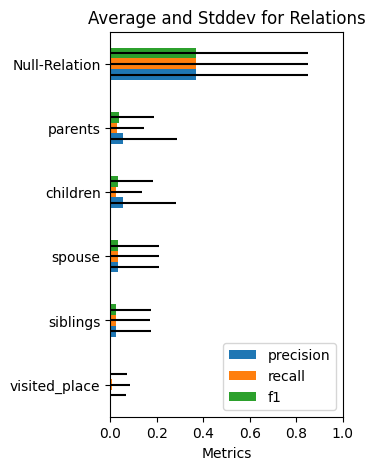

In [5]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics

# children/parents/siblings/spouse/visited_place
# Define your ontology
your_ontology = {
    "Null-Relation", 
    "visited_place", # "visitors_of_place", "residents_of_place", "place_of_residence",
    "siblings", "spouse", "children", "parents", # "other_family", "pet", "acquaintance", 
    # "Attachment"
    # "title", "alternate_names", "place_of_work", "unanswerable"
    }

# your_ontology = list(config.allowed_relations)

# your_ontology = config.all_relations
# Usage
my_metrics = RelationGranularMetrics(df, your_ontology)
result = my_metrics.process()
chart_df = my_metrics.to_dataframe()
my_metrics.plot_metrics(chart_df, figsize=(3,5))
# my_metrics.plot_metrics(chart_df, figsize=(4,12))


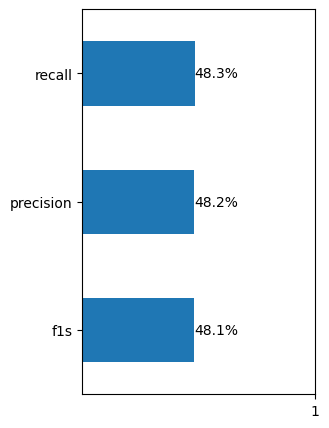

In [6]:
import matplotlib.pyplot as plt

# Your plotting code here
ax = df[['f1s', 'precision', 'recall']].mean().plot(kind='barh', alpha=1, figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])

# Adding data values on top of each bar
for bar in ax.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1%}', 
             va='center', ha='left')

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

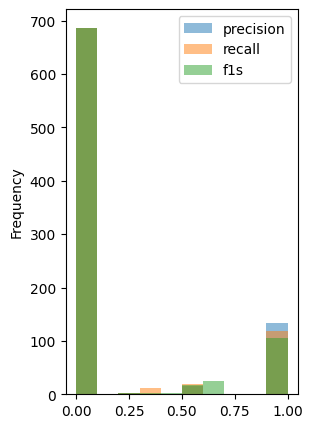

In [6]:
df[['precision', 'recall', 'f1s']].fillna(0).plot(kind='hist', alpha=0.5, figsize=(3, 5))


In [204]:
print(config.preprompt)

Extract entities and relations from the dialogue. Return a Python list of JSON objects, each fitting this schema: {"subject": "<Entity>", "subject_type": "<Animal/Organization/Location/Person/Date/Event>", "relation": "<acquaintance/children/other_family/parents/pet/place_of_residence/residents_of_place/siblings/spouse/visited_place/visitors_of_place>", "object": "<Related Entity>", "object_type": "<Animal/Organization/Location/Person/Date/Event>"}. No additional text or explanations. Return an empty list if no relevant entities or relations are found. Stick to the provided types and relations. You are like an API, you don't speak you only return JSON objects.
Dialogue: {input_dialogue}


In [9]:
dialogue = 'Speaker 1: Hi, you are my father.\nSpeaker 2: Yes, I am your father'
# dialogue = 'Speaker 1: I went to Maryland.\nSpeaker 2: Why?\nSpeaker 1: I work at Google there.'
# dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! What is his name?\nSpeaker 1: John.'
# dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! '
jsonl = evaluator.infer_from_model(dialogue, preprompt=config.preprompt)
print(dialogue)

try:
    print(jsonl.replace('},', '},\n'))
except Exception as e:
    print(f'Exception={e}')
    print(jsonl)

Speaker 1: Hi, you are my father.
Speaker 2: Yes, I am your father

Extract personal relevant entities, and their relations. Return only the jsonl format list. Extract entities and relations from the given dialogue input and generate a JSON list as output that is structured according to the entity and relation types from the ontology.

Ontology: 
- relations: {"place_of_residence", "siblings", "residents_of_place", "visited_place", "visitors_of_place", "other_family", "parents", "pet", "acquaintance", "children", "spouse"}
- types: {"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}

Input:
[
"Speaker 1: Hi, you are my father.",
"Speaker 2: Yes, I am your father",
]

Output:
[
{"subject": "Speaker 1", "subject_type": "PERSON", "relation": "siblings", "object": "Speaker 2", "object_type": "PERSON"},

{"subject": "Speaker 2", "subject_type": "PERSON", "relation": "siblings", "object": "Speaker 1", "object_type": "PERSON"},

{"subject": "Speaker 1", "subject_type": "PERSON", "relation": "